<a href="https://colab.research.google.com/github/EduFdezSoy/safety-first/blob/master/simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safety helmet detector

Source: https://www.kaggle.com/ehddnr301/helmet-classification

In [1]:
# Uncomment for install tensorflow 1.15.
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 512kB 60.5MB/s 
     |████████████████████████████████| 3.8MB 48.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=6971fda1a87f140cb3baec6961a91dfd9146ae4517e1cd372fc2ff5cc8640457
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [2]:
# Imports
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
from skimage import io, transform
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, MaxPooling2D, Dropout
# Check Tensorflow version.
tf.version.VERSION

'1.15.0'

## 1. Loading Data

In [3]:
# Uncomment for clonning the repository
!git clone https://github.com/sergiorodenas/ml-data.git

Cloning into 'ml-data'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 13271 (delta 2), reused 0 (delta 0), pack-reused 13236
Receiving objects: 100% (13271/13271), 67.06 MiB | 38.07 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [4]:
# Image constants
IMAGE_WIDTH=100
IMAGE_HEIGHT=100
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
PATH1='./ml-data/helmet-dataset/Train_positive/Train_positive/'
PATH2='./ml-data/helmet-dataset/Train_negative/Train_negative/'

In [5]:
# Getting the images
filenames_list_yes = []
filenames_list_no = []

for filename in os.listdir(PATH1):
    filenames_list_yes.append(PATH1 + filename)
    
for filename in os.listdir(PATH2):
    filenames_list_no.append(PATH2 + filename)

df_yes = pd.DataFrame({
    'image': filenames_list_yes,
    'category': np.ones(len(filenames_list_yes), str)
})
df_no = pd.DataFrame({
    'image': filenames_list_no,
    'category': np.zeros(len(filenames_list_no), str)
})
print(df_yes.shape, df_no.shape)
df = df_yes.append(df_no, ignore_index=True)
print(df['image'][0])

(5160, 2) (6580, 2)
./ml-data/helmet-dataset/Train_positive/Train_positive/2338.jpg


## 2. Training data

In [6]:
# Hyperparameters
BATCH_SIZE=32
EPOCHS=100

In [7]:
#split data into train and valid set
train_df, valid_df = train_test_split(df, test_size = 0.15, stratify = df['category'], random_state = 3)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]
print(train_df.shape)
print(valid_df.shape)

(9979, 2)
(1761, 2)


In [8]:
#We'll perform individually on train and validation set.
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   )

train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col = 'image',
                                              y_col = 'category',
                                              target_size = IMAGE_SIZE,
                                              batch_size = BATCH_SIZE,
                                              class_mode='binary',
                                              validate_filenames=False
                                             )

#we do not augment validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)
valid_gen = validation_datagen.flow_from_dataframe(
    valid_df, 
    x_col="image",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    validate_filenames=False
)

Found 9979 non-validated image filenames belonging to 2 classes.
Found 1761 non-validated image filenames belonging to 2 classes.


In [9]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', strides=(2,2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'Precision'])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 49, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 141376)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               36192512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

## 3. Train the model

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint(filepath = 'mask.weights.best.hdf5', save_best_only = True, save_weights_only = True)
early_stop = EarlyStopping(monitor='val_loss', patience=6)
callbacks = [learning_rate_reduction, checkpointer, early_stop]

In [12]:
start = time.time()

model.fit_generator(train_gen,
                    epochs = EPOCHS,
                    validation_data = valid_gen,
                    validation_steps=total_valid//BATCH_SIZE,
                    steps_per_epoch=total_train//BATCH_SIZE,
                    callbacks = callbacks)

endTime = time.time() - start
print("Total time: ", endTime, "seconds")

Epoch 1/100
311/311 [==============================] - 19s 61ms/step - loss: 0.2856 - acc: 0.9260 - precision: 0.9166 - val_loss: 0.1032 - val_acc: 0.9545 - val_precision: 0.9873
Epoch 2/100
311/311 [==============================] - 11s 37ms/step - loss: 0.0953 - acc: 0.9623 - precision: 0.9598 - val_loss: 0.0782 - val_acc: 0.9688 - val_precision: 0.9851
Epoch 3/100
311/311 [==============================] - 12s 37ms/step - loss: 0.0708 - acc: 0.9754 - precision: 0.9703 - val_loss: 0.0644 - val_acc: 0.9756 - val_precision: 0.9906
Epoch 4/100
311/311 [==============================] - 12s 37ms/step - loss: 0.0528 - acc: 0.9806 - precision: 0.9766 - val_loss: 0.0599 - val_acc: 0.9739 - val_precision: 0.9815
Epoch 5/100
311/311 [==============================] - 11s 37ms/step - loss: 0.0575 - acc: 0.9805 - precision: 0.9780 - val_loss: 0.0628 - val_acc: 0.9767 - val_precision: 0.9753
Epoch 6/100
311/311 [==============================] - 12s 37ms/step - loss: 0.0370 - acc: 0.9880 - preci

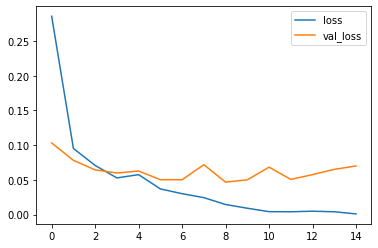

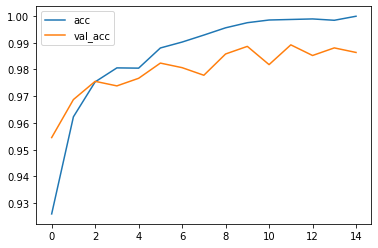

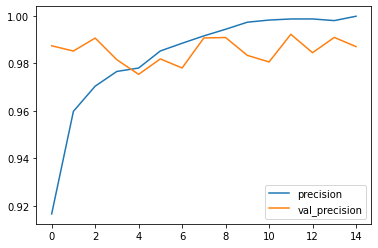

In [13]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
loss[['acc', 'val_acc']].plot()
loss[['precision', 'val_precision']].plot()

In [14]:
loss_mean = loss.mean()
loss_mean

loss             0.046386
acc              0.985557
precision        0.983399
val_loss         0.063315
val_acc          0.979697
val_precision    0.985297
lr               0.000750
dtype: float64

In [15]:
print("Epochs: ", len(model.history.epoch))
print("Train time: ", endTime, "seconds") 

Epochs:  15
Train time:  180.3516206741333 seconds


In [16]:
print("| simple | {} | {} |  {} |   {} |  {} |      {} | {} |      {} |   {} |     |".format(loss_mean.acc, loss_mean.loss, loss_mean.val_acc, loss_mean.val_loss, loss_mean.precision, loss_mean.val_precision, loss_mean.lr, len(model.history.epoch), endTime))

| simple | 0.9855567773183187 | 0.046386406617462635 |  0.9796969691912333 |   0.06331467519221616 |  0.9833989938100179 |      0.9852965712547302 | 0.0007500000356230885 |      15 |   180.3516206741333 |     |
